#Question1#


In [1]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=08fcb3de402ee9c2546e5e989ef1ca226244628ca25b2dfa662f80b3ebb6d63b
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting un

In [32]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
              sklearn_sm,
              poly,
              ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import cross_validate, KFold

In [3]:
from pygam import (s as s_gam,
           l as l_gam,
           f as f_gam,
           LinearGAM,
           LogisticGAM)

from ISLP.transforms import (BSpline,
                NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
             degrees_of_freedom,
             plot as plot_gam,
             anova as anova_gam)


In [25]:
Boston = load_data('Boston')
# Data.describe()
y = Boston['nox']
dis = Boston['dis']


In [27]:
# (a)
poly_dis = MS([poly('dis', degree=3)]).fit(Boston)
M = sm.OLS(y, poly_dis.transform(Boston)).fit()
summarize(M)


,coef,std err,t,P>|t|
intercept,0.5547,0.003,201.021,0.0
"poly(dis, degree=3)[0]",-2.0031,0.062,-32.271,0.0
"poly(dis, degree=3)[1]",0.8563,0.062,13.796,0.0
"poly(dis, degree=3)[2]",-0.3180,0.062,-5.124,0.0


In [29]:
def plot_nox_fit(dis_df,
         basis,
         title):

    X = basis.transform(Boston)
    Xnew = basis.transform(dis_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(dis,
          y,
          facecolor='gray',
          alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(dis_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Dis', fontsize=20)
    ax.set_ylabel('Nox', fontsize=20);
    return ax


In [28]:
dis_grid = np.linspace(dis.min(),
             dis.max(),
             100)
dis_df = pd.DataFrame({'dis': dis_grid})


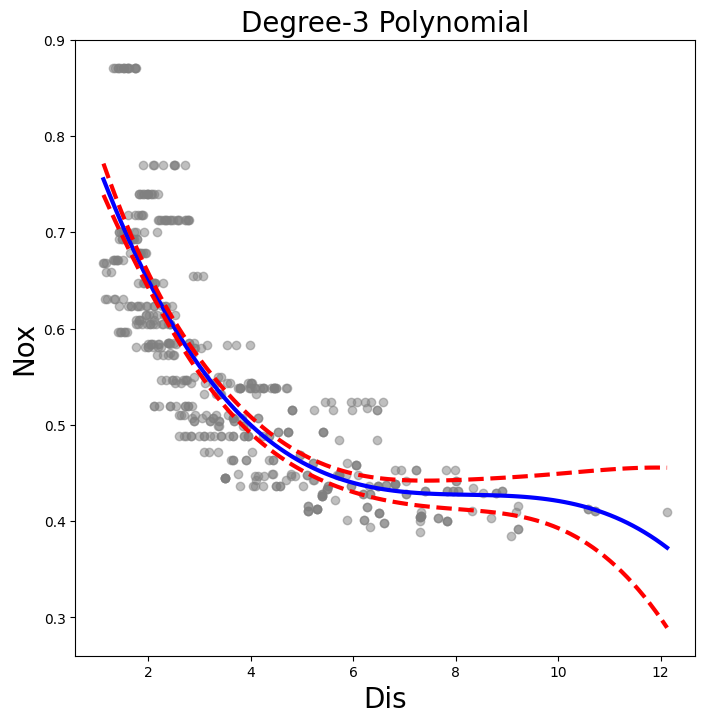

In [30]:
plot_nox_fit(dis_df,
       poly_dis,
       'Degree-3 Polynomial');


In [41]:
# (b)
def get_RSS(dis_df, basis, d):
  X = basis.transform(Boston)
  Xnew = basis.transform(dis_df)
  M = sm.OLS(y, X).fit()
  y_fitted = M.fittedvalues
  residuals = y - y_fitted
  rss = np.sum(residuals ** 2)
  return rss


Residual Sum of Squares of Degree-1 Polynomial: 2.7685628589692755
Residual Sum of Squares of Degree-2 Polynomial: 2.0352618689352564
Residual Sum of Squares of Degree-3 Polynomial: 1.9341067071790703
Residual Sum of Squares of Degree-4 Polynomial: 1.9329813272985947
Residual Sum of Squares of Degree-5 Polynomial: 1.9152899610843044
Residual Sum of Squares of Degree-6 Polynomial: 1.878257298508164
Residual Sum of Squares of Degree-7 Polynomial: 1.8494836145829787
Residual Sum of Squares of Degree-8 Polynomial: 1.8356296890676882
Residual Sum of Squares of Degree-9 Polynomial: 1.8333308044915937
Residual Sum of Squares of Degree-10 Polynomial: 1.8321711239313427


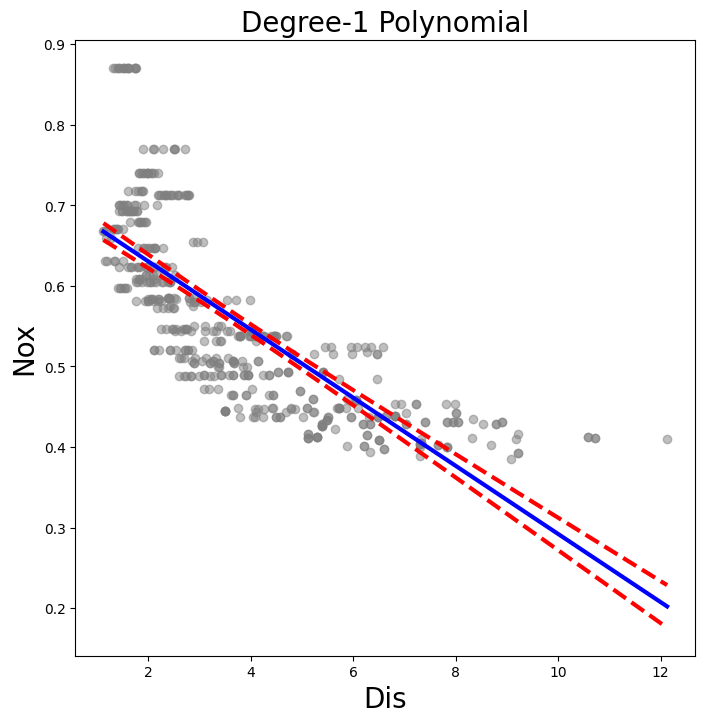

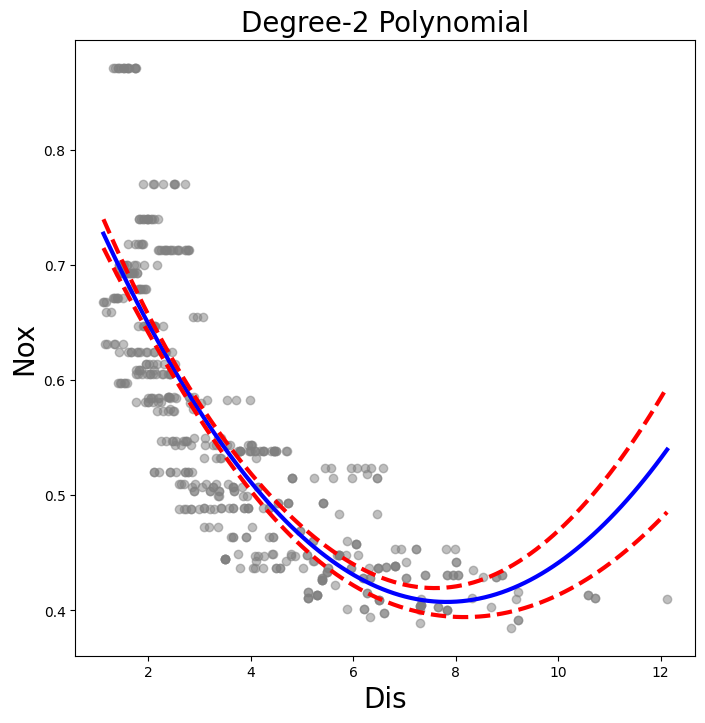

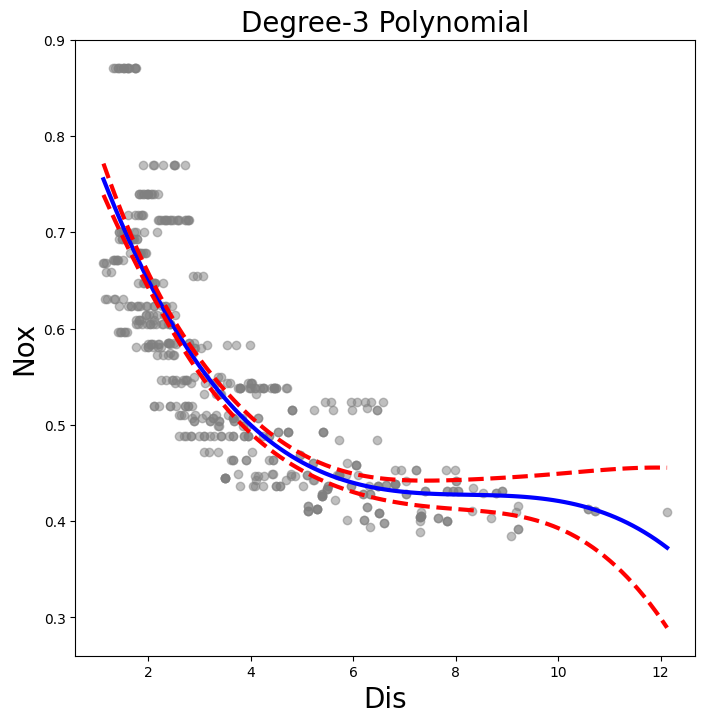

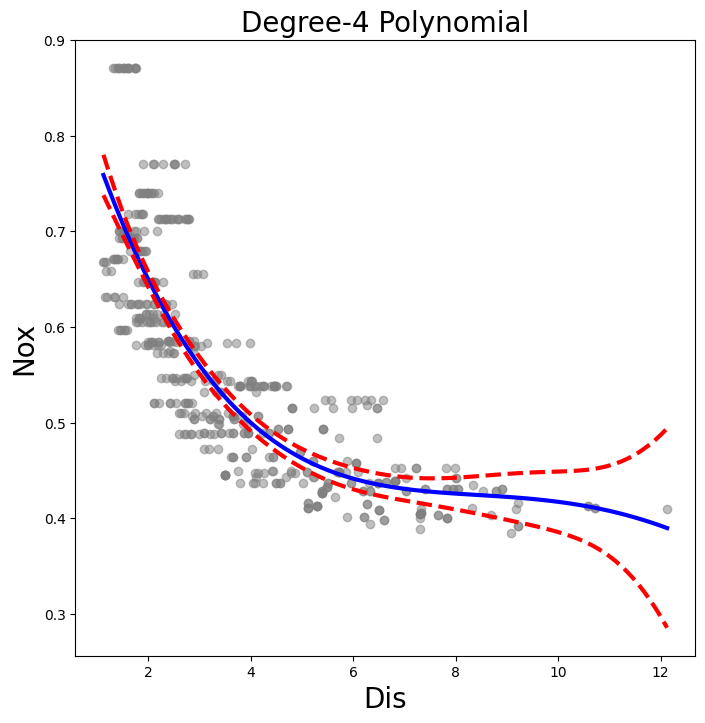

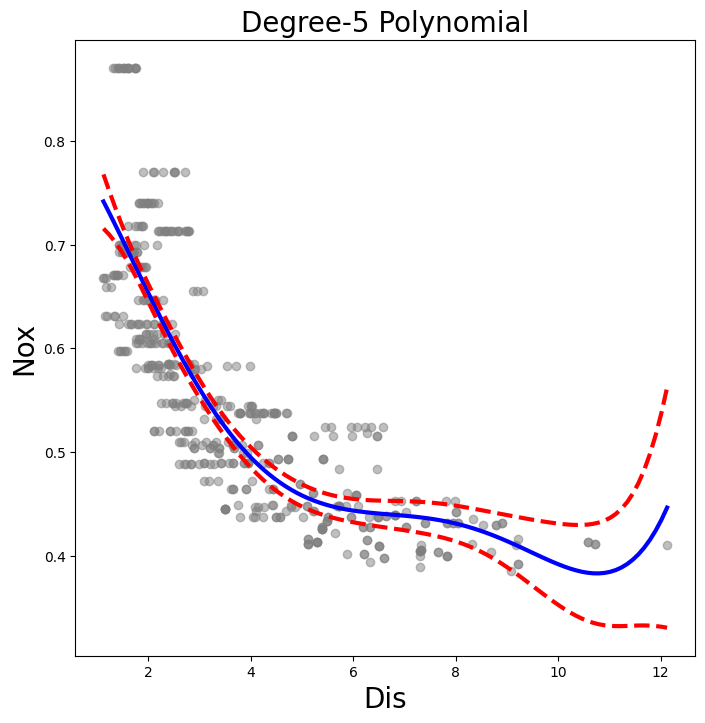

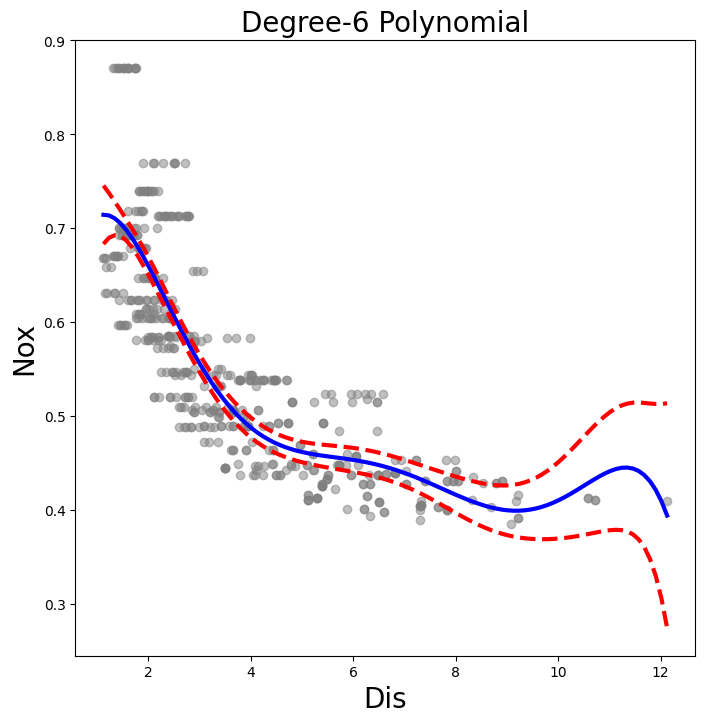

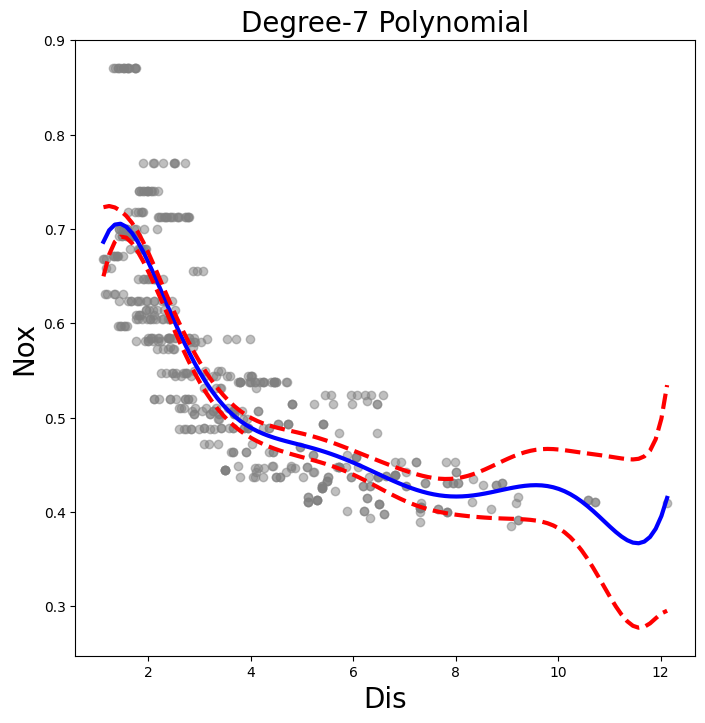

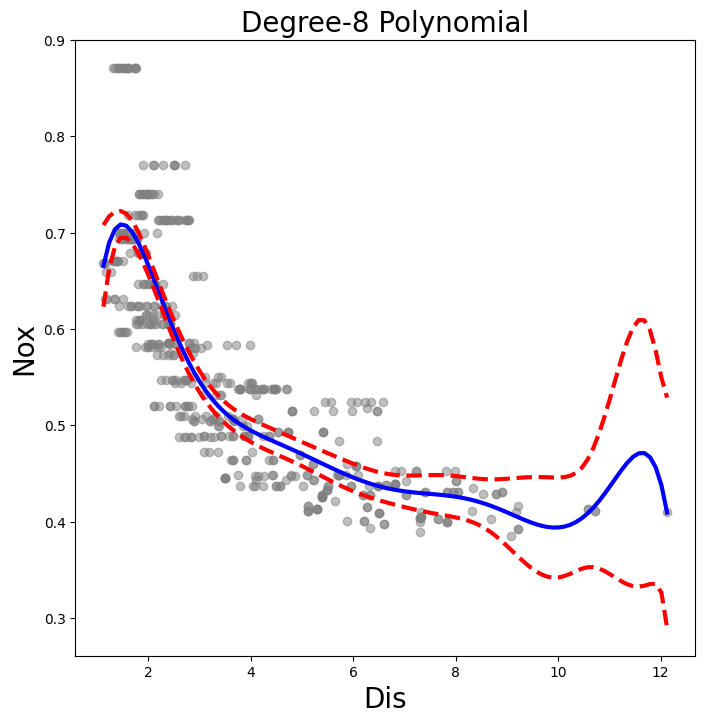

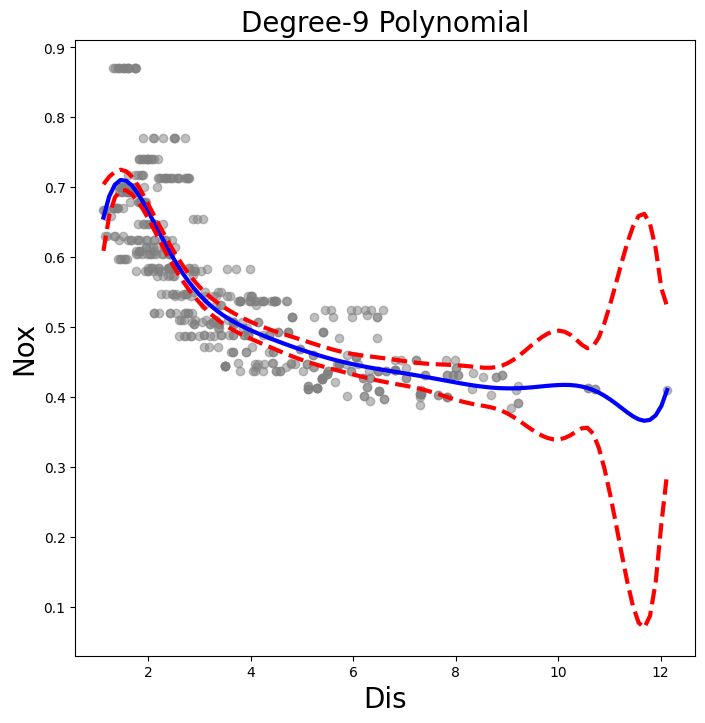

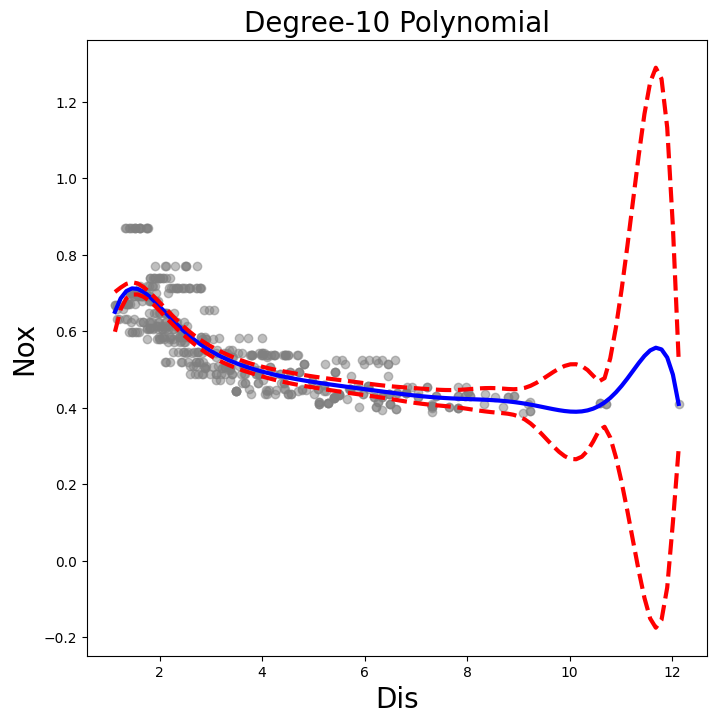

In [44]:
for d in range(1, 11):
  model = MS([poly('dis', degree=d)])
  X = model.fit(Boston)
  plot_nox_fit(dis_df, X, 'Degree-{} Polynomial'.format(d))
  # get_RSS(dis_df, X ,d)
  print("Residual Sum of Squares of Degree-{d} Polynomial: {rss}".format(d=d,rss=get_RSS(dis_df, X ,d)))



In [34]:
# Using cross validation to find the best polynomial degree. cv=5
cv_error = np.zeros(11)
H = np.array(dis)
M = sklearn_sm(sm.OLS)
#Let's introduce splits.
cv = KFold(n_splits=5,shuffle=True,random_state=0)
for i, d in enumerate(range(1,12)):
    Xcross = np.power.outer(H, np.arange(d+1))
    Mat_CV = cross_validate(M,Xcross,y,cv=cv)
    cv_error[i] = np.mean(Mat_CV['test_score'])
cv_error

array([0.00550455, 0.00404589, 0.00384482, 0.00385288, 0.00405327,
       0.00490166, 0.00711742, 0.0065405 , 0.02188365, 0.00468493,
       0.0525854 ])

We should choose the poly with degree 3

In [35]:
#(d)
bs_dis = MS([bs('dis', df=4)]).fit(Boston)
M_bs = sm.OLS(y, bs_dis.transform(Boston)).fit()
summarize(M_bs)


,coef,std err,t,P>|t|
intercept,0.7345,0.015,50.306,0.000
"bs(dis, df=4)[0]",-0.0581,0.022,-2.658,0.008
"bs(dis, df=4)[1]",-0.4636,0.024,-19.596,0.000
"bs(dis, df=4)[2]",-0.1998,0.043,-4.634,0.000
"bs(dis, df=4)[3]",-0.3888,0.046,-8.544,0.000


<Axes: title={'center': 'Regression spline fit of nox on dis with 4 df'}, xlabel='Dis', ylabel='Nox'>

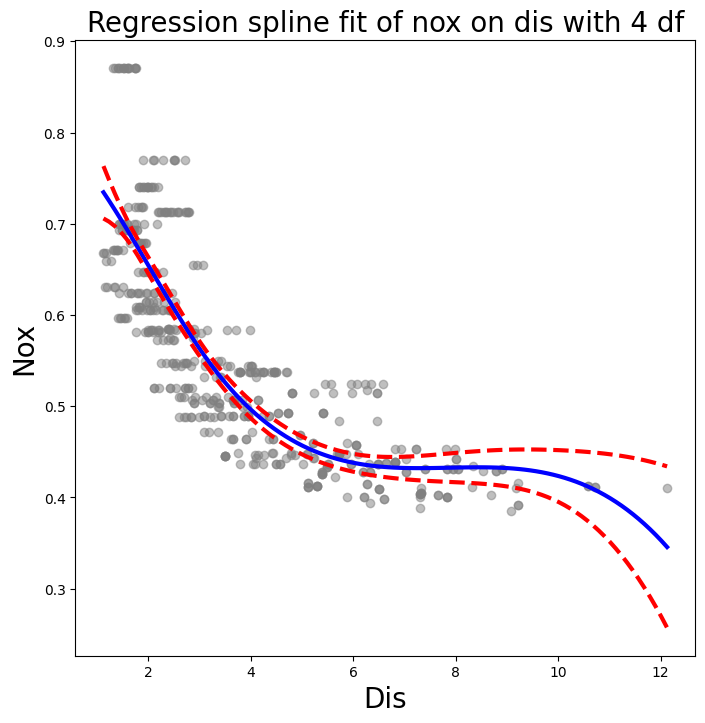

In [36]:
plot_nox_fit(dis_df, bs_dis, 'Regression spline fit of nox on dis with 4 df')

The knots are automatically chosen as the four quartiles

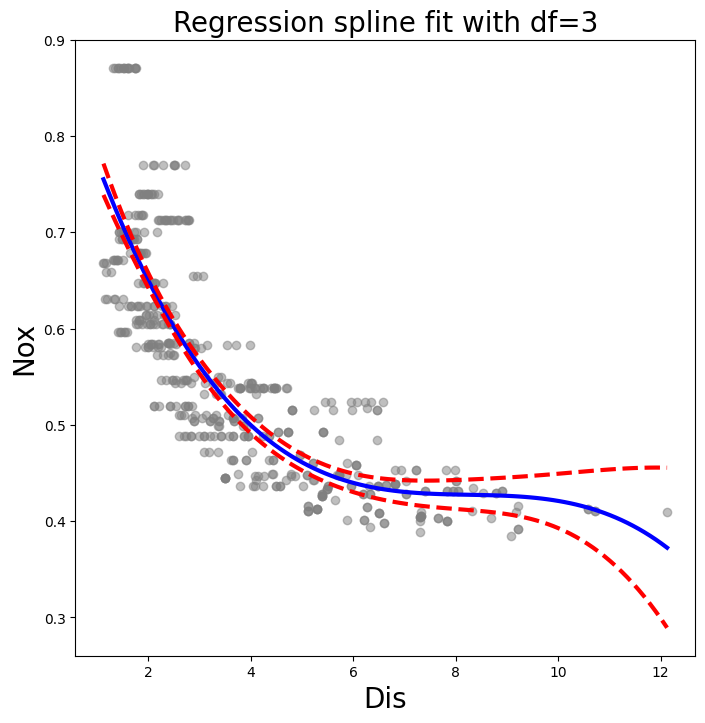

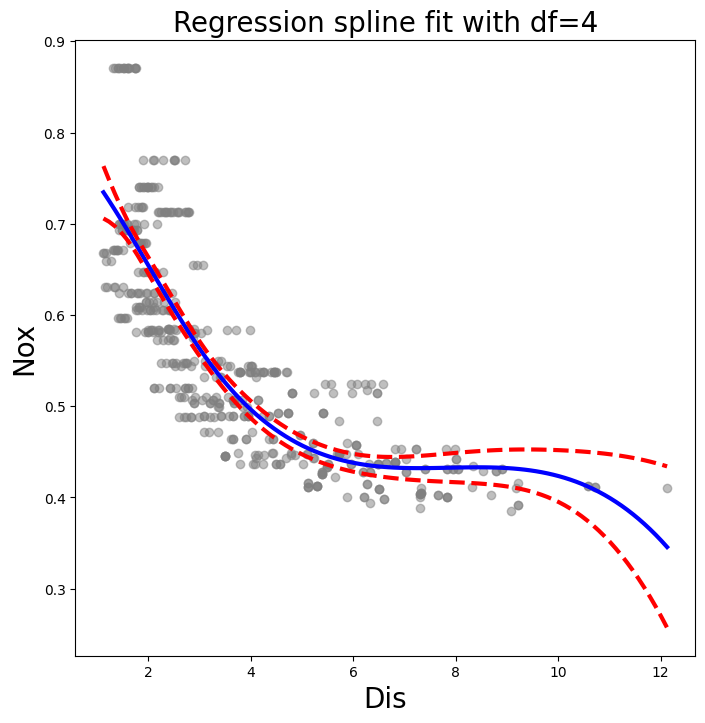

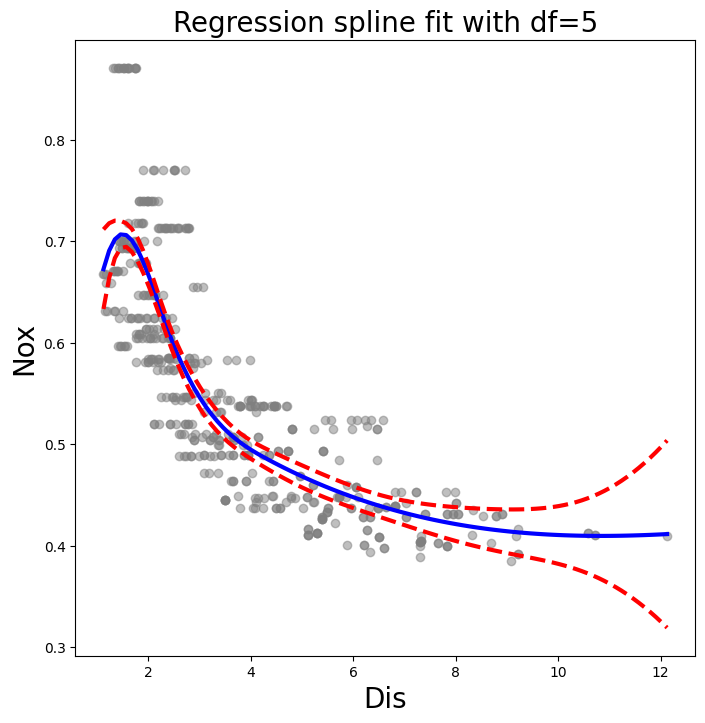

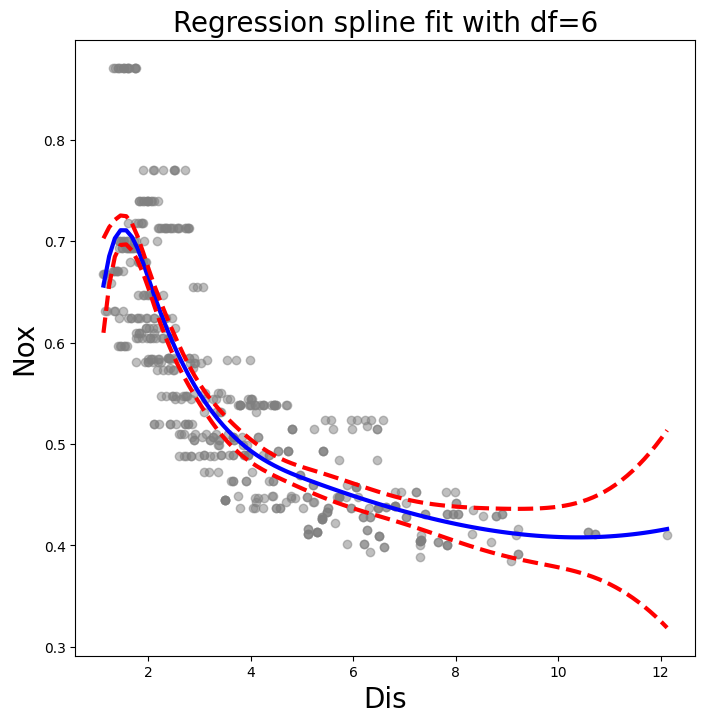

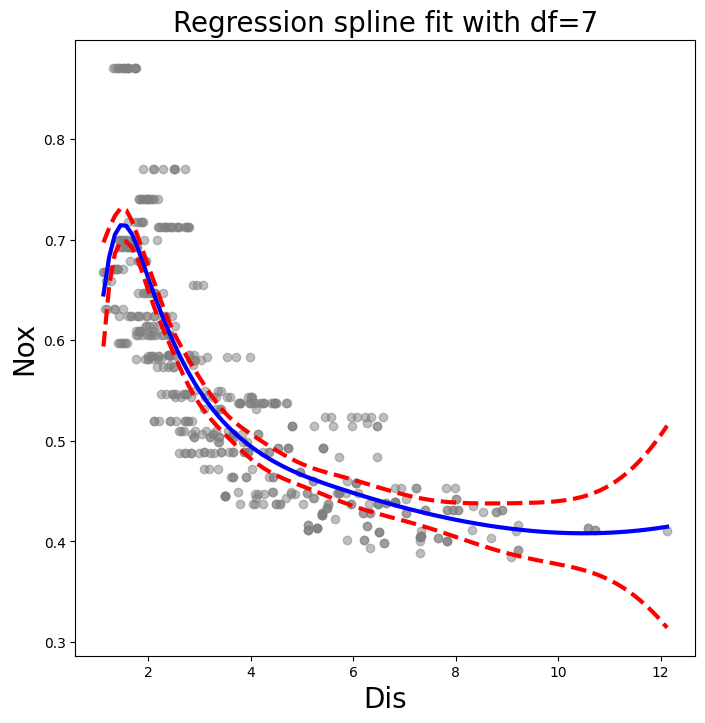

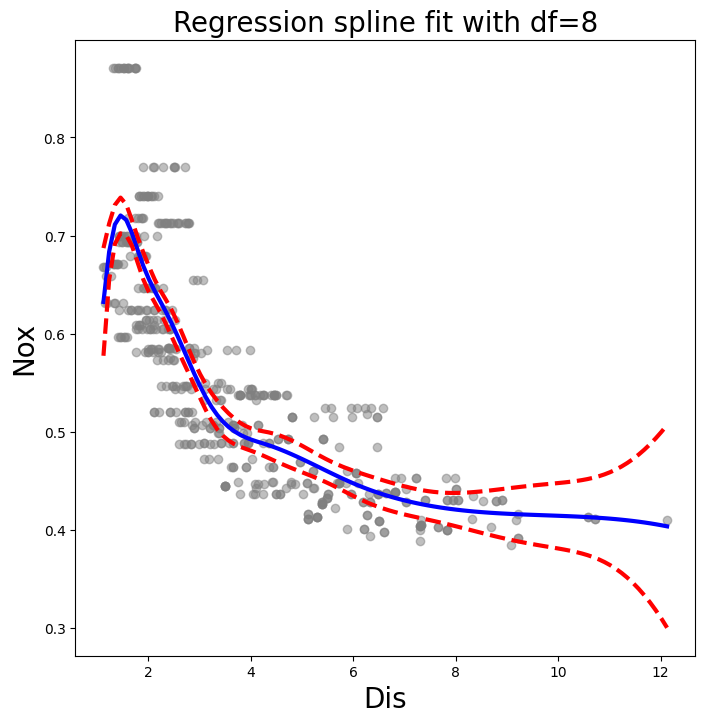

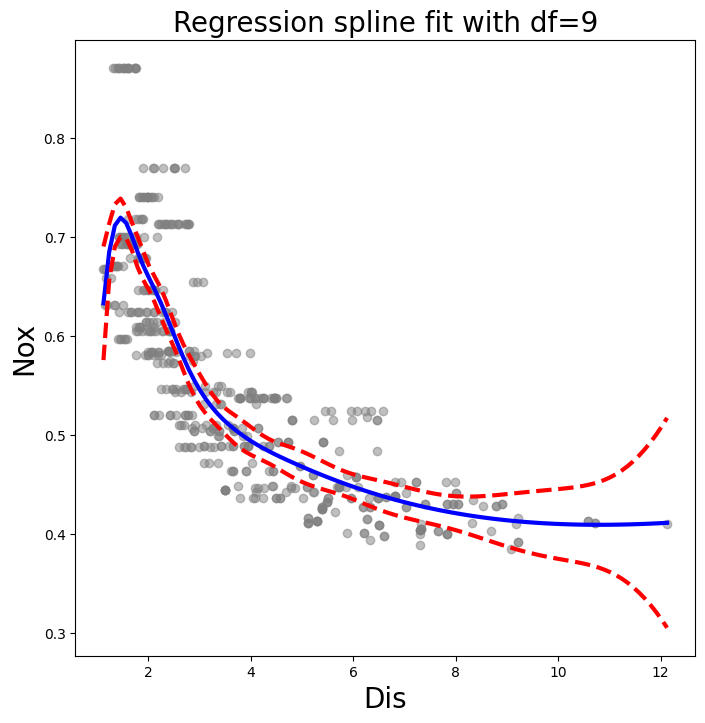

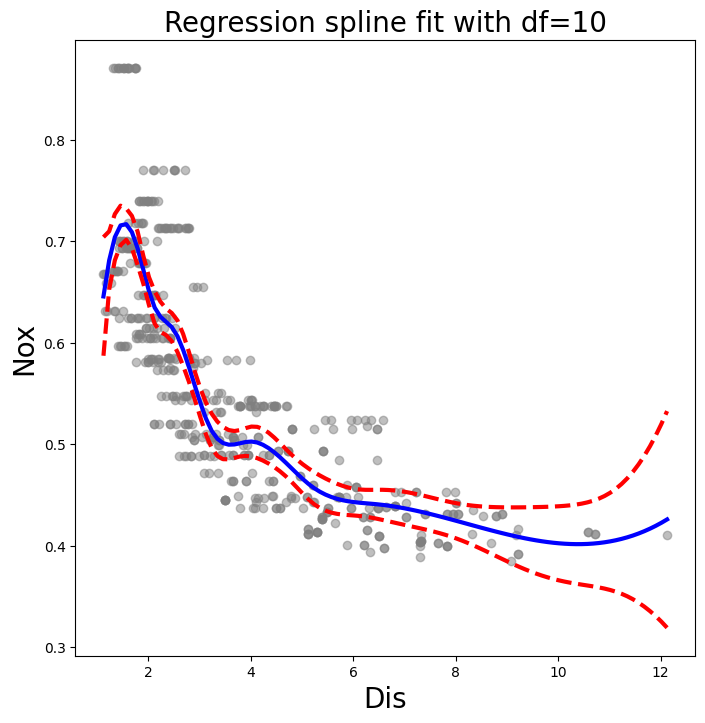

In [58]:
RSS={}
for d in range(3, 11):
  model = MS([bs('dis', df=d)])
  X = model.fit(Boston)
  plot_nox_fit(dis_df, X, 'Regression spline fit with df={}'.format(d))
  RSS[d] = get_RSS(dis_df, X ,d)


In [50]:
pd.DataFrame(RSS,index = ['RSS']).T

,RSS
3,1.934107
4,1.922775
5,1.840173
6,1.833966
7,1.829884
8,1.816995
9,1.825653
10,1.792535


The training RSS decreases with the increasement of the degrees of freedom. We cannot decide which is the best regression spline model.

In [57]:
# (f)
# Using cross validation to find the best regression spline model. cv=10
cv_error = np.zeros(9)
M = sklearn_sm(sm.OLS)
cv = KFold(n_splits=10,shuffle=True,random_state=1)
for d in range(3,12):
    bs_dis = MS([bs('dis', df=d)]).fit(Boston)
    Xcross = bs_dis.transform(Boston)
    Mat_CV = cross_validate(M,Xcross,y,cv=cv)
    cv_error[d-3] = np.mean(Mat_CV['test_score'])
cv_error

array([0.00387002, 0.00388453, 0.0037093 , 0.0037177 , 0.00372454,
       0.00371579, 0.00375893, 0.00371381, 0.00373558])

The optimal model is obtained for 5 degrees of freedom

#Question2#

In [55]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

In [51]:
Carseats = load_data("Carseats")
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)


In [53]:
# (a)
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                 Carseats['Sales'],
                 test_size=0.3,
                 random_state=0)

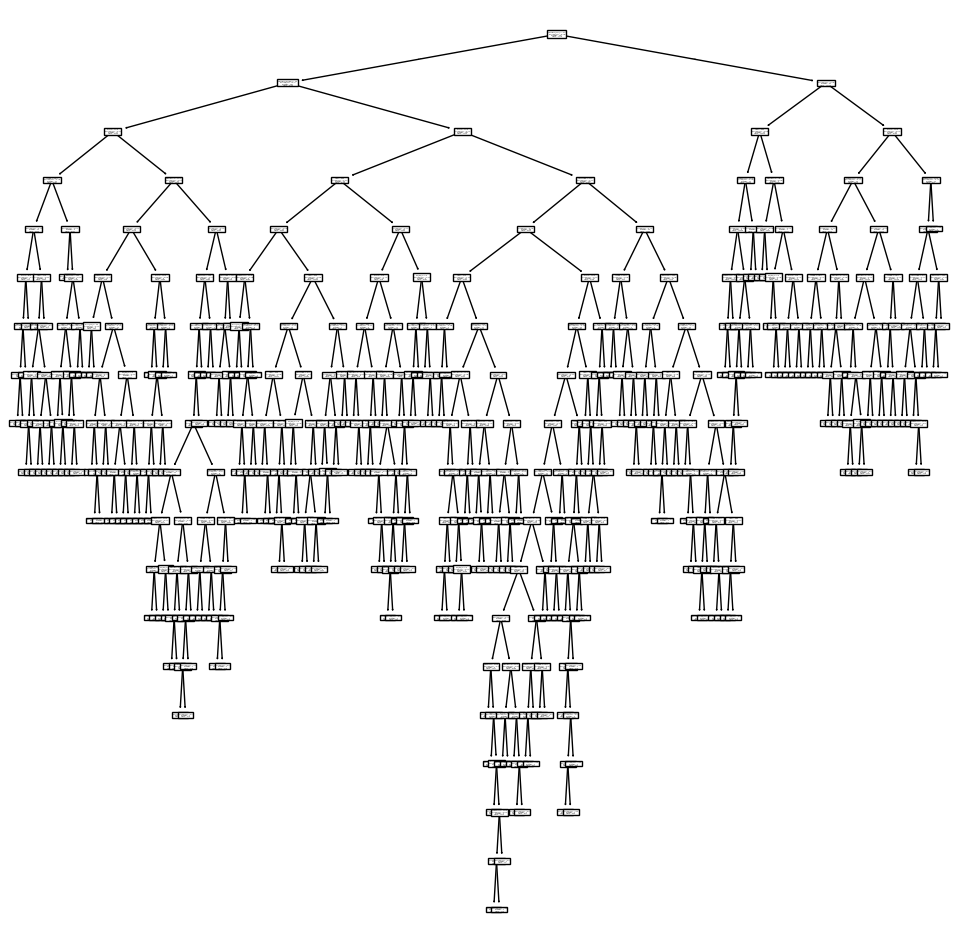

In [64]:
# (b)
reg = DTR()
result = reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
     feature_names=feature_names,
     ax=ax);

interpret the result:
The first feature is "Shelvel[]"
If the first feature is True, then the next   
IF the  

In [66]:
MSE = np.mean((y_test - reg.predict(X_test))**2)
print(MSE)

5.072710833333334


The MSE is 3.70

In [65]:
result.get_depth()

18

In [67]:
# (c) Pruning the tree
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
          shuffle=True,
          random_state=10)
grid = skm.GridSearchCV(reg,
             {'ccp_alpha': ccp_path.ccp_alphas},
             refit=True,
             cv=kfold,
             scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

4.561883219912132

The test MSE after pruning the tree is 4.56, which is better than the test MSE of the full regression tree

In [68]:
# (d)
bag_carseats = RF(max_features=X_train.shape[1], random_state=0)
bag_carseats.fit(X_train, y_train)
# ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_carseats.predict(X_test)
# ax.scatter(y_hat_bag, y_test)
bag_MSE = np.mean((y_test - y_hat_bag)**2)
print(bag_MSE)

2.0077445197500015


The test MSE associated with the bagged regression tree is 2.00 which is nearly half of the previous one


In [70]:
feature_imp = pd.DataFrame(
    {'importance':bag_carseats.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.278666
ShelveLoc[Good],0.222431
Age,0.108637
CompPrice,0.097085
ShelveLoc[Medium],0.082965
Advertising,0.074627
Income,0.051799
Population,0.040945
Education,0.030836
US[Yes],0.006815


Top 3 most important predictors are: price, ShelveLoc and age

In [71]:
# (e)
RF_Carseats = RF(max_features=6,
         random_state=0).fit(X_train, y_train)
y_hat_RF = RF_Carseats.predict(X_test)
RF_Test_MSE = np.mean((y_test - y_hat_RF)**2)
print(RF_Test_MSE)

feature_imp = pd.DataFrame(
    {'importance':RF_Carseats.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)


2.010414251


,importance
Price,0.274081
ShelveLoc[Good],0.185368
Age,0.116413
CompPrice,0.103326
Advertising,0.083759
Income,0.064661
ShelveLoc[Medium],0.062402
Population,0.054959
Education,0.036506
US[Yes],0.011148


In [72]:
# m = 3
RF_Carseats_3 = RF(max_features=3,
         random_state=0).fit(X_train, y_train)
y_hat_RF = RF_Carseats_3.predict(X_test)
RF_Test_MSE = np.mean((y_test - y_hat_RF)**2)
print(RF_Test_MSE)

2.303643984083332


In [73]:
# m = 9
RF_Carseats_9 = RF(max_features=9,
         random_state=0).fit(X_train, y_train)
y_hat_RF = RF_Carseats_9.predict(X_test)
RF_Test_MSE = np.mean((y_test - y_hat_RF)**2)
print(RF_Test_MSE)

2.1159908063333335
